In [2]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Set up training data

# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi))

In [4]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [5]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [6]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.911   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.878   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.842   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.801   lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.756   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.705   lengthscale: 0.475   noise: 0.474
Iter 7/50 - Loss: 0.651   lengthscale: 0.439   noise: 0.437
Iter 8/50 - Loss: 0.595   lengthscale: 0.405   noise: 0.402
Iter 9/50 - Loss: 0.541   lengthscale: 0.372   noise: 0.369
Iter 10/50 - Loss: 0.491   lengthscale: 0.342   noise: 0.339
Iter 11/50 - Loss: 0.444   lengthscale: 0.315   noise: 0.310
Iter 12/50 - Loss: 0.401   lengthscale: 0.292   noise: 0.284
Iter 13/50 - Loss: 0.359   lengthscale: 0.272   noise: 0.259
Iter 14/50 - Loss: 0.318   lengthscale: 0.256   noise: 0.236
Iter 15/50 - Loss: 0.276   lengthscale: 0.243   noise: 0.215
Iter 16/50 - Loss: 0.234   lengthscale: 0.233   noise: 0.195
Iter 17/50 - Loss: 0.191   length

In [10]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    f_pred = model(test_x)
    observed_pred = likelihood(model(test_x))

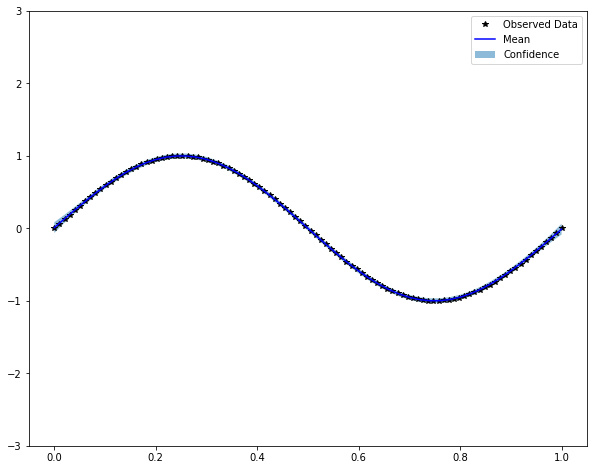

In [11]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 8))

    # Get upper and lower confidence bounds
#     lower, upper = observed_pred.confidence_region()
    lower, upper = f_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [12]:
f_pred.confidence_region()

(tensor([-0.0642,  0.0755,  0.2068,  0.3288,  0.4422,  0.5474,  0.6440,  0.7307,
          0.8059,  0.8681,  0.9159,  0.9482,  0.9649,  0.9654,  0.9500,  0.9189,
          0.8728,  0.8124,  0.7386,  0.6526,  0.5558,  0.4497,  0.3360,  0.2164,
          0.0930, -0.0324, -0.1576, -0.2810, -0.4004, -0.5142, -0.6204, -0.7174,
         -0.8038, -0.8780, -0.9387, -0.9851, -1.0162, -1.0316, -1.0311, -1.0150,
         -0.9836, -0.9373, -0.8770, -0.8036, -0.7179, -0.6215, -0.5166, -0.4061,
         -0.2946, -0.1864, -0.0849]),
 tensor([ 0.0849,  0.1865,  0.2946,  0.4061,  0.5166,  0.6216,  0.7179,  0.8036,
          0.8771,  0.9373,  0.9836,  1.0151,  1.0312,  1.0316,  1.0161,  0.9851,
          0.9388,  0.8780,  0.8038,  0.7175,  0.6204,  0.5142,  0.4004,  0.2810,
          0.1576,  0.0324, -0.0930, -0.2164, -0.3360, -0.4497, -0.5558, -0.6527,
         -0.7386, -0.8124, -0.8728, -0.9189, -0.9500, -0.9654, -0.9650, -0.9484,
         -0.9159, -0.8681, -0.8059, -0.7307, -0.6441, -0.5475, -0.4422,

In [20]:
for i in likelihood.named_parameters():
    print(i)

('noise_covar.raw_noise', Parameter containing:
tensor([-5.2793], requires_grad=True))
